In [1]:
using NLsolve, Plots, Distributions, StatsPlots

struct Calibration
    σ::Float64           # elasticity of relative demand with respect to price         
    γ::Vector{Float64}   # intensity in each good
    ϵ::Vector{Float64}   # elasticity of relative demand with respect to income in luxury good sector
end

cal = Calibration(
    0.5,                    # sigma=0.5 completementary goods
    [1/3, 1/3, 1/3],        #intensity
    [0.6, 1.0, 1.65],       #ELASTICITIES
)

ρ=(cal.σ-1)/cal.σ

-1.0

In [2]:
#NH Utility Function
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    E=sum(p[i]*C[i] for i=1:length(C))
    out=1-sum(cal.γ[i]^(1/cal.σ)*(((p[i]/E)^(-cal.σ)*cal.γ[i])/u^((1-cal.σ)*cal.σ*cal.ϵ[i]))^ρ for i=1:length(C))
    return out
end

function NHUtility(C::Vector{Float64}, p::Vector{Float64} ;cal=cal,tol=1e-10,T=100)
    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C endowment
    U=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p[i]*C[i] for i=1:length(C))
    ExpNH=sum(cal.γ[i]*U^(cal.ϵ[i]*cal.σ*(1-cal.σ)) * (p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*cal.σ*(1-cal.σ))  * (p[1]/E)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*cal.σ*(1-cal.σ))  * (p[2]/E)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*cal.σ*(1-cal.σ))  * (p[3]/E)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*cal.σ*(1-cal.σ))  * (p[1]/E)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*cal.σ*(1-cal.σ))  * (p[2]/E)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*cal.σ*(1-cal.σ))  * (p[3]/E)^(1-cal.σ)

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    return [C1, C2, C3, U]#, U, E, ω]

end

function GEprices(Endow::Vector{Any}, p::Vector{Float64} ; cal=cal, tol=1e-1)
    ng=3                    #nber of good
    na=10.0                 #max unit for one good type
    W=zeros(ng)             #Endowment
    D=zeros(ng)             #NH Demand
    Excess=zeros(ng)
    pricepath=[]
    
    #First value for excess, 
    #1. if D>W Price increases
    #2. if D<W Price drops
    for i=1:ng
        W[i]=sum(Endow[j,:][1][i] for j=1:length(Endow))
        D[i]=sum(NHUtility(Endow[j,:][1],p)[i] for j=1:length(Endow))
    end

    Excess= D-W

    for j=1:ng
        while abs(Excess[j])>tol
            pricepath=push!(pricepath,[p[1], p[2], p[3]])

            for i=1:ng
                p[i]=p[i]+0.001*Excess[i]
                W[i]=sum(Endow[j,:][1][i] for j=1:length(Endow))
                D[i]=sum(NHUtility(Endow[j,:][1],p)[i] for j=1:length(Endow))
            end
            Excess=D-W
        end
    end
        
    return pricepath
end

GEprices (generic function with 1 method)

In [77]:
#Prices and Endowment vector for everyone 
p=[3.0, 6.0, 7.0]
Endow=[]
sca=5.0
for i = 1:sca
    for j=1:sca
        for k =1:sca
            Endow=push!(Endow, [i, j, k])
        end
    end
end
Endow;

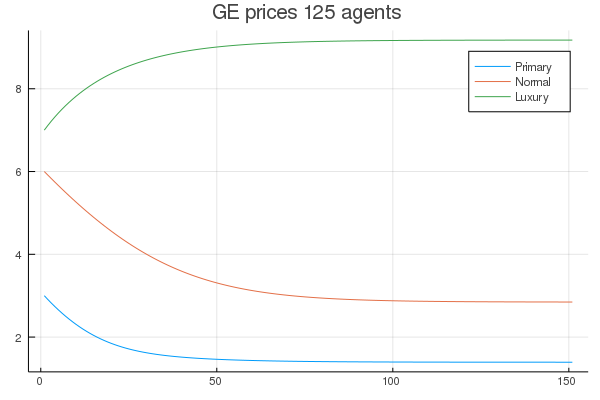

In [78]:
pricep=GEprices(Endow,p)
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices 125 agents", label=["Primary" "Normal" "Luxury"])

In this example, prices were first given at p=[10.0, 2.0, 4.0].
However, this price level does not clear the market, we have demand that takes over endowment level in our economy

In [169]:
ng=3
na=100

100

In [170]:
G=zeros(ng,na)
for i =1:ng
    for j=1:na
        G[i,j]=rand(1.0:1.0:10.0)
    end
end

G

3×100 Matrix{Float64}:
 1.0  6.0  1.0  10.0  5.0   2.0  4.0  …  7.0  3.0  8.0  10.0  7.0   6.0  4.0
 3.0  9.0  8.0   4.0  6.0   9.0  2.0     8.0  6.0  3.0   5.0  4.0   6.0  9.0
 8.0  5.0  8.0   5.0  6.0  10.0  1.0     6.0  7.0  4.0   7.0  5.0  10.0  9.0

In [171]:
p=[3.0, 4.0, 7.0]

3-element Vector{Float64}:
 3.0
 4.0
 7.0

In [172]:
Go=transpose(G)

100×3 transpose(::Matrix{Float64}) with eltype Float64:
  1.0  3.0   8.0
  6.0  9.0   5.0
  1.0  8.0   8.0
 10.0  4.0   5.0
  5.0  6.0   6.0
  2.0  9.0  10.0
  4.0  2.0   1.0
 10.0  6.0  10.0
  2.0  3.0   8.0
 10.0  1.0   7.0
  ⋮         
  6.0  5.0   8.0
 10.0  2.0   2.0
  7.0  8.0   6.0
  3.0  6.0   7.0
  8.0  3.0   4.0
 10.0  5.0   7.0
  7.0  4.0   5.0
  6.0  6.0  10.0
  4.0  9.0   9.0

In [173]:
Exp=[]
for a = 1:Int(length(G)/ng)
    E=sum(p[i]*Go[a,i] for i = 1:ng)
    Exp=push!(Exp,E)
end
Exp

100-element Vector{Any}:
  71.0
  89.0
  91.0
  81.0
  81.0
 112.0
  27.0
 124.0
  74.0
  83.0
   ⋮
  94.0
  52.0
  95.0
  82.0
  64.0
  99.0
  72.0
 112.0
 111.0

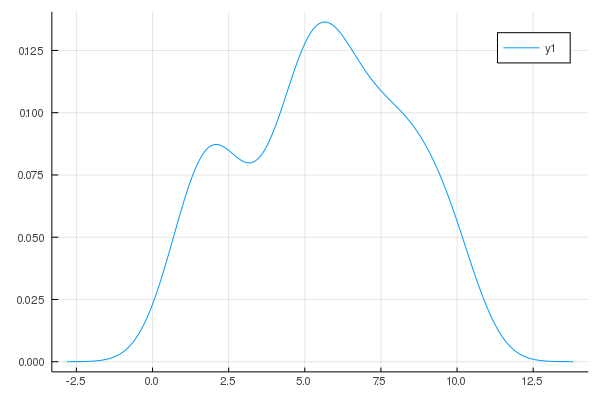

In [184]:
tri=[Go Exp]
tri=sortslices(tri,dims=1,by=x->(x[4]),rev=false)

density(tri[:,3])

In [175]:
function GEpricesincomerand(G::Matrix{Float64}, p::Vector{Float64} ; cal=cal, tol=1e-3)
    G=transpose(G)
    ng=3                    #nber of good
    na=10.0                 #max unit for one good type
    W=zeros(ng)             #Endowment
    D=zeros(ng)             #NH Demand
    Excess=zeros(ng)
    pricepath=[]
    #First value for excess, 
    #1. if D>W Price increases
    #2. if D<W Price drops
    for i=1:ng
        W[i]=sum(G[j,i] for j=1:length(na))
        D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:length(na))
    end

    Excess= D-W

    for j=1:ng
        while abs(Excess[j])>tol
            pricepath=push!(pricepath,[p[1], p[2], p[3]])

            for i=1:ng
                p[i]=p[i]+0.001*Excess[i]
                W[i]=sum(G[j,i] for j=1:length(na))
                D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:length(na))
            end
            Excess=D-W
        end
    end
        
    return pricepath
end

GEpricesincomerand (generic function with 1 method)

In [176]:
G

3×100 Matrix{Float64}:
 1.0  6.0  1.0  10.0  5.0   2.0  4.0  …  7.0  3.0  8.0  10.0  7.0   6.0  4.0
 3.0  9.0  8.0   4.0  6.0   9.0  2.0     8.0  6.0  3.0   5.0  4.0   6.0  9.0
 8.0  5.0  8.0   5.0  6.0  10.0  1.0     6.0  7.0  4.0   7.0  5.0  10.0  9.0

In [177]:
p=[4.0, 5.0, 15.0]


3-element Vector{Float64}:
  4.0
  5.0
 15.0

In [159]:
p=[2.0, 6.0, 7.0]


3-element Vector{Float64}:
 2.0
 6.0
 7.0

In [178]:
pricep=GEpricesincomerand(G,p)


44489-element Vector{Any}:
 [4.0, 5.0, 15.0]
 [4.002848528196164, 5.002388468498355, 14.998444236258937]
 [4.005695678364972, 5.004775654308235, 14.99688830921356]
 [4.0085413317127365, 5.007161284706215, 14.995332219149974]
 [4.011385490499055, 5.009545361642614, 14.993775966358948]
 [4.014228156969801, 5.0119278870632895, 14.992219551130628]
 [4.017069333364681, 5.014308862909657, 14.990662973754546]
 [4.019909021917262, 5.016688291118703, 14.989106234519614]
 [4.022747224854994, 5.019066173622996, 14.98754933371413]
 [4.0255839443992345, 5.021442512350705, 14.985992271625783]
 ⋮
 [15.724506141173816, 3.866245205215221, 1.9714144628093433]
 [15.724506417581468, 3.866244203293285, 1.9714142236194498]
 [15.724506693926426, 3.8662432015983352, 1.9714139844837637]
 [15.724506970208703, 3.8662422001303205, 1.9714137454022724]
 [15.724507246428312, 3.8662411988891896, 1.971413506374964]
 [15.724507522585268, 3.8662401978748915, 1.971413267401826]
 [15.724507798679587, 3.866239197087374, 1.

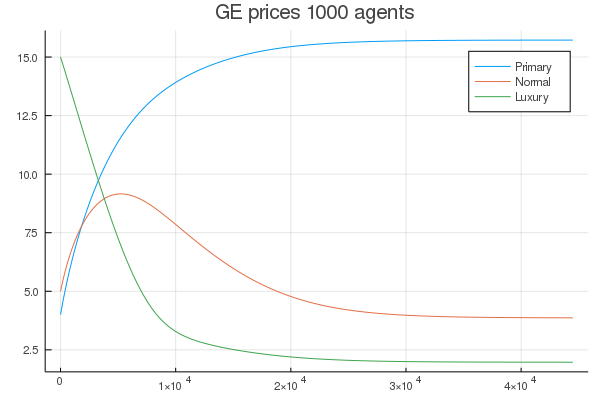

In [179]:
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end
plot([p_p p_n p_l], title="GE prices 1000 agents", label=["Primary" "Normal" "Luxury"])